In [1]:
import os
import re
import subprocess
import psutil
import time
import threading
import pandas as pd
import json

In [2]:
max_memory_usage = 0
cpu_times_user = 0
cpu_times_system = 0
process_finished = threading.Event()

In [3]:
database_path = "smart_contracts_database/vulnerable_contracts"
sc_projects = sorted(os.listdir(database_path))
sc_projects

['AggregationRouterV5_0x1111111254eeb25477b68fb85ed929f73a960582',
 'AggregationRouterV6_0x111111125421ca6dc452d289314280a0f8842a65',
 'AllowanceHolder_0x0000000000001ff3684f28c67538d4d072c22734',
 'ChainflipFacet_0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae',
 'DexRouterV105_0x2E1Dee213BA8d7af0934C49a23187BabEACa8764',
 'DexRouterV106_0xf6801d319497789f934ec7f83e142a9536312b08',
 'DexRouterV107_0x5E1f62Dac767b0491e3CE72469C217365D5B48cC',
 'Diamond_0xb300000b72deaeb607a12d5f54773d1c19c7028d',
 'FastMCTP_0xC1062b7C5Dc8E4b1Df9F200fe360cDc0eD6e7741',
 'GnosisSafe_0x67e254c61b3Fc5F5eD92f3004063b21CD0B46B6b',
 'InstaDefaultImplementation_0x01d1f55d94a53a9517c07f793f35320FAA0D2DCf',
 'MetaAggregationRouterV2_0x6131b5fae19ea4f9d964eac0408e4408b66337b5',
 'NonfungiblePositionManager_0xC36442b4a4522E871399CD717aBDD847Ab11FE88',
 'StakingPool_0x29403B1AC2B745c806e4d4988e4C1B6F4c119b95',
 'SwapRouter02_0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45',
 'TransitSwapRouterV5_0x00000047bB99ea4D791bb749D97

In [4]:
def monitor_resources(process_pid):
    global max_memory_usage, cpu_times_user, cpu_times_system
    try:
        p = psutil.Process(process_pid)
        # Enable monitoring of child processes created by this process
        p.children(recursive=True) 
        
        while not process_finished.is_set():
            try:
                # Measure memory usage (Resident Set Size in bytes)
                mem_info = p.memory_info()
                if mem_info.rss > max_memory_usage:
                    max_memory_usage = mem_info.rss
                
                # Sleep briefly before the next sample
                time.sleep(0.1)
            except psutil.NoSuchProcess:
                break
        
        # After the process finishes, get final cumulative CPU times
        try:
            cpu_times = p.cpu_times()
            cpu_times_user = cpu_times.user
            cpu_times_system = cpu_times.system
        except psutil.NoSuchProcess:
            pass

    except psutil.NoSuchProcess:
        print(f"Process {process_pid} not found for monitoring.")

In [5]:
def get_solidity_pragma_version(file_path):
    """
    Extracts the Solidity pragma version string from a .sol file using regex.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
            f.close()
            # Regex to find the pragma solidity line and capture the version part
            # It handles various spacing and version range operators like ^, >=, <, etc.
            match = re.search(r'pragma\s+solidity\s+([^;]+);', content)
            if match:
                # The captured group (index 1) contains the version constraint string
                version_constraint = match.group(1).strip()
                return version_constraint
            else:
                return "Pragma not found"
    except FileNotFoundError:
        return f"Error: The file {file_path} was not found."
    except Exception as e:
        return f"An error occurred: {e}"

In [6]:
def set_solc_version(sc_path):
    sc_version = get_solidity_pragma_version(sc_path).replace("^", "")
    if ">=" in sc_version:
        sc_version = sc_version.split(" ")[0].replace(">=", "")
    elif "<=" in sc_version:
        sc_version = sc_version.split(" ")[1].replace("<=", "")
    else:
        sc_version = sc_version.replace("=", "")
    
    print("Solidity version:", sc_version)

    # Run the command to install solc and capture output
    try:
        install_command = ["solc-select", "install", f"{sc_version}"]
        result = subprocess.run(install_command, capture_output=True, text=True, check=True)
        use_command = ["solc-select", "use", f"{sc_version}"]
        result = subprocess.run(use_command, capture_output=True, text=True, check=True)
        if result.returncode != 0:
            print("ERROR DURING SOLC INSTALATION!")
            return False
        else:
            print("`solc` successfully installed and changed!")
            return True
    except subprocess.CalledProcessError as e:
        print(f"`solc-select` command failed with return code {e.returncode}")
        print("STDOUT:", e.stdout)
        print("STDERR:", e.stderr)
        return False

In [7]:
def run_slither():
    global process_finished
    slither_command = ["slither", ".", "--detect", "static-sandwich", "--json", "output.json"]

    start_time = time.time()

    try:
        # Start the subprocess
        process = subprocess.Popen(slither_command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        process_pid = process.pid

        # Start a separate thread for monitoring
        monitor_thread = threading.Thread(target=monitor_resources, args=(process_pid,))
        monitor_thread.start()

        # Wait for the subprocess to complete
        process.wait()
        end_time = time.time()
        
        # Signal the monitoring thread to stop
        process_finished.set()
        monitor_thread.join()
        
        stdout, _ = process.communicate()
        with open("exec.log", "w") as f:
            f.write(stdout)
            f.close()

        # Calculate metrics
        real_time = end_time - start_time
        # Convert max memory from bytes to MiB
        max_memory_mib = max_memory_usage / (1024 * 1024) 
        total_cpu_time = cpu_times_user + cpu_times_system

        print("\n--- Subprocess Metrics ---")
        print(f"Real Time (wall clock): {real_time:.2f} seconds")
        print(f"Total CPU Time (user + system): {total_cpu_time:.2f} seconds")
        print(f"Max RAM Usage (RSS): {max_memory_mib:.2f} MiB")

        print("`slither` executed successfully!\n")
        return [real_time, max_memory_mib, total_cpu_time]
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
    

In [8]:
df_result = pd.DataFrame({"Project": [], "Time (s)": [], "RAM (MB)": [], "CPU (s)": []})
df_result

,Project,Time (s),RAM (MB),CPU (s)


In [9]:
for project in sc_projects:
    sc_name = project.split("_")[0]
    print(f"Running tests for {sc_name}.sol...")
    sc_path = f"{database_path}/{project}/src/{sc_name}.sol"
    
    if not set_solc_version(sc_path):
        break

    # Run slither
    os.chdir(f"{database_path}/{project}/src")
    new_row_data = run_slither()
    if new_row_data is not None:
        df_result.loc[df_result.shape[0]] = [sc_name] + new_row_data
    os.chdir("../../../..")

    max_memory_usage = 0
    cpu_times_user = 0
    cpu_times_system = 0
    process_finished = threading.Event()

Running tests for AggregationRouterV5.sol...
Solidity version: 0.8.17
`solc` successfully installed and changed!

--- Subprocess Metrics ---
Real Time (wall clock): 3.41 seconds
Total CPU Time (user + system): 0.00 seconds
Max RAM Usage (RSS): 144.67 MiB
`slither` executed successfully!

Running tests for AggregationRouterV6.sol...
Solidity version: 0.8.23
`solc` successfully installed and changed!

--- Subprocess Metrics ---
Real Time (wall clock): 28.91 seconds
Total CPU Time (user + system): 0.00 seconds
Max RAM Usage (RSS): 159.54 MiB
`slither` executed successfully!

Running tests for AllowanceHolder.sol...
Solidity version: 0.8.25
`solc` successfully installed and changed!

--- Subprocess Metrics ---
Real Time (wall clock): 2.77 seconds
Total CPU Time (user + system): 0.00 seconds
Max RAM Usage (RSS): 59.25 MiB
`slither` executed successfully!

Running tests for ChainflipFacet.sol...
Solidity version: 0.8.17
`solc` successfully installed and changed!

--- Subprocess Metrics ---
R

In [10]:
df_result

,Project,Time (s),RAM (MB),CPU (s)
0,AggregationRouterV5,3.408448,144.671875,0
1,AggregationRouterV6,28.905594,159.542969,0
2,AllowanceHolder,2.767329,59.253906,0
3,ChainflipFacet,1.623653,71.671875,0
4,DexRouterV105,5.666455,169.621094,0
5,DexRouterV106,7.174634,205.781250,0
6,DexRouterV107,7.373005,209.878906,0
7,Diamond,0.958469,47.281250,0
8,FastMCTP,2.118889,72.542969,0
9,GnosisSafe,1.188394,60.566406,0


In [11]:
for i, project in enumerate(sc_projects):
    try:
        with open(f"{database_path}/{project}/src/output.json", "r") as f:
            output = json.load(f)
            f.close()
        if output["success"] and output['results']:
            df_result.loc[i, "Detected"] = "Yes"
            df_result.loc[i, "Error"] = "No"
        else:
            df_result.loc[i, "Detected"] = "No"
            df_result.loc[i, "Error"] = "No"
    except:
        df_result.loc[i, "Detected"] = "No"
        df_result.loc[i, "Error"] = "Yes"
df_result

,Project,Time (s),RAM (MB),CPU (s),Detected,Error
0,AggregationRouterV5,3.408448,144.671875,0,Yes,No
1,AggregationRouterV6,28.905594,159.542969,0,Yes,No
2,AllowanceHolder,2.767329,59.253906,0,No,No
3,ChainflipFacet,1.623653,71.671875,0,No,No
4,DexRouterV105,5.666455,169.621094,0,Yes,No
5,DexRouterV106,7.174634,205.781250,0,Yes,No
6,DexRouterV107,7.373005,209.878906,0,Yes,No
7,Diamond,0.958469,47.281250,0,No,No
8,FastMCTP,2.118889,72.542969,0,Yes,No
9,GnosisSafe,1.188394,60.566406,0,No,No


In [12]:
df_result.to_excel("First round of results.xlsx", index=False)

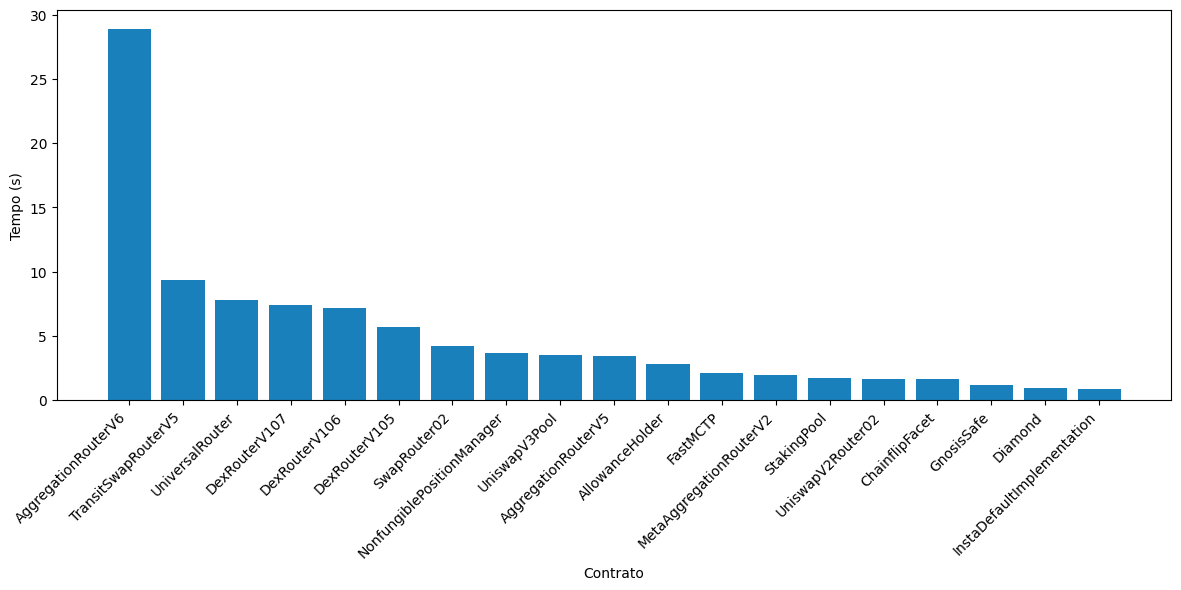

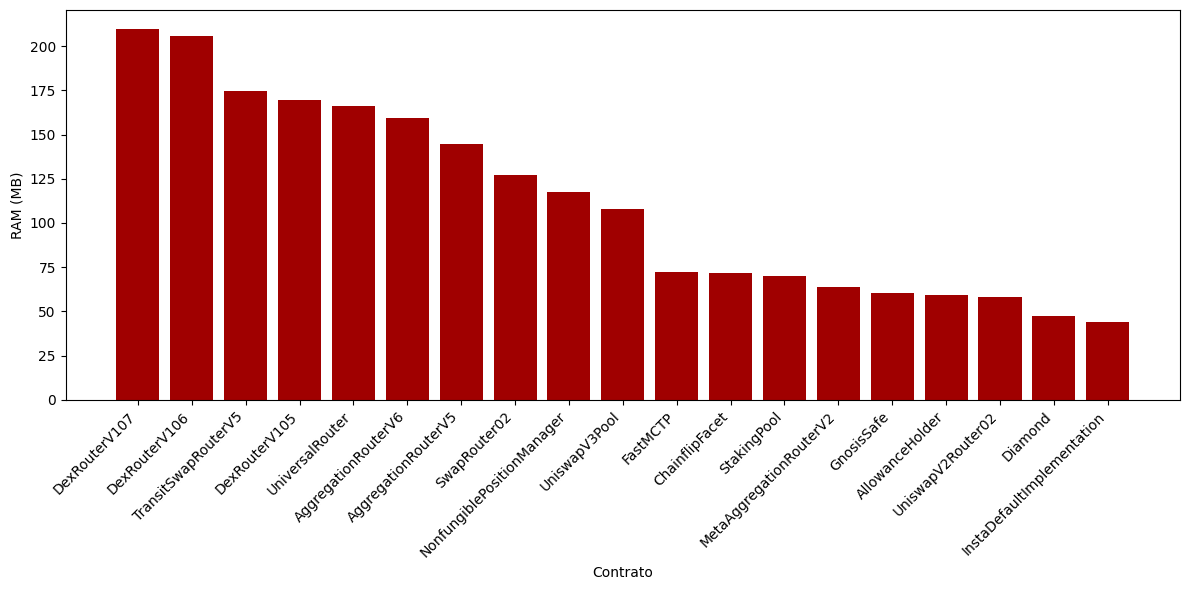

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the data
# Replace with your actual file path if running locally
file_path = 'First round of results.xlsx'
df = pd.read_excel(file_path)

# 2. Aggregate data by 'Contrato' (taking the mean for duplicate entries)
df_grouped = df.groupby('Project').mean(numeric_only=True).reset_index()

# 3. Create Bar Plot for Time (s)
# Sort values to make the chart easier to read
df_time = df_grouped.sort_values(by='Time (s)', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(df_time['Project'], df_time['Time (s)'], color='#1a80bb')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Contrato')
plt.ylabel('Tempo (s)')
# plt.title('Tempo de Execução por Contrato')
plt.tight_layout()
plt.savefig('time_plot.pdf')
plt.show()

# 4. Create Bar Plot for RAM (MB)
# Sort values to make the chart easier to read
df_ram = df_grouped.sort_values(by='RAM (MB)', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(df_ram['Project'], df_ram['RAM (MB)'], color='#a00000')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Contrato')
plt.ylabel('RAM (MB)')
# plt.title('Uso de RAM por Contrato')
plt.tight_layout()
plt.savefig('ram_plot.pdf')
plt.show()

In [14]:
df.describe()

,Time (s),RAM (MB),CPU (s)
count,19.000000,19.000000,19.0
mean,5.037820,112.084293,0.0
std,6.324896,55.989126,0.0
min,0.813158,44.125000,0.0
25%,1.696624,62.255859,0.0
50%,3.408448,107.781250,0.0
75%,6.420545,162.699219,0.0
max,28.905594,209.878906,0.0
